In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.stackers as stackers
import copy
import numpy as np

/Users/yoachim/lsst/DarwinX86/anaconda/2.2.0/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [5]:
class m5Stacker(stackers.BaseStacker):
    
    def __init__(self, skybCol='filtSkyBrightness', filterCol='filter', airmassCol='airmass', seeingCol='FWHMeff',
                expTime=30.):
        self.units = ['mag']
        self.colsAdded = ['fiveSigmaD']
        self.colsReq = [skybCol,filterCol,airmassCol,seeingCol]
        self.skybCol = skybCol
        self.filterCol = filterCol
        self.airmassCol = airmassCol
        self.seeingCol = seeingCol
        self.expTime = expTime
        
        # Values from overview paper
        self.kAtm = {'u':0.451,'g':0.163,'r':0.087,'i':0.065,'z':0.043,'y':0.138}
        self.Cm = {'u':22.92,'g':24.29,'r':24.33,'i':24.20,'z':24.07,'y':23.69}
        self.dCm_infinity = {'u':0.67,'g':0.21,'r':0.11,'i':0.08,'z':0.05,'y':0.04}
        
    def _run(self, simData):
        filters = np.unique(simData[self.filterCol])
        for filterName in filters:
            good = np.where(simData[self.filterCol] == filterName)
            simData['fiveSigmaD'][good] = self.Cm[filterName] +0.5*(simData[self.skybCol][good] - 21.) + 2.5*np.log10(0.7/simData[self.seeingCol][good]) + 1.25*np.log10(self.expTime/30.) - self.kAtm[filterName]*(simData[self.airmassCol][good]-1.) 

            
        return simData
                 

In [6]:
runNames = ['enigma_1189', 'minion_1016']
outDir = 'astrometry_test'
resultsDb = db.ResultsDb(outDir=outDir)
filters = ['u', 'g', 'r', 'i', 'z', 'y']

In [7]:
stackerList = [m5Stacker(seeingCol='finSeeing')]
for runName in ['enigma_1189']:
    opsdb = db.OpsimDatabase(runName+'_sqlite.db')
    propids, propTags = opsdb.fetchPropInfo()
    WFDpropid = propTags['WFD'][0]
    slicer = slicers.UniSlicer()
    bundleList = []
    for filterName in filters:
        sql = 'propID = %i and filter="%s" and moonAlt < %f and sunAlt < %f' % (WFDpropid, filterName, np.radians(-10.), np.radians(-18.))
        # sqls.append('propID = %i and filter="%s"' % (WFDpropid, filterName))

        bundleList.append(metricBundles.MetricBundle(metrics.MedianMetric(col='filtSkyBrightness'), slicer, sql))
        bundleList.append(metricBundles.MetricBundle(metrics.MedianMetric(col='fiveSigmaDepth'), slicer, sql, stackerList=stackerList))
        bundleList.append(metricBundles.MetricBundle(metrics.MedianMetric(col='fiveSigmaD'), slicer, sql, stackerList=stackerList))

        bundleList.append(metricBundles.MetricBundle(metrics.MedianMetric(col='airmass'), slicer, sql))
        if runName == 'enigma_1189':
            bundleList.append(metricBundles.MetricBundle(metrics.MedianMetric(col='finSeeing'), slicer, sql))
        else:
            bundleList.append(metricBundles.MetricBundle(metrics.MedianMetric(col='FWHMeff'), slicer, sql))
    bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
    bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
    bgroup.runAll()
    print '--------'
    print runName
    for bundle in bundleList:
        print bundle.constraint, bundle.metric.name, bundle.metricValues
    print '--------'
enigma_BL = copy.deepcopy(bundleList)

Querying database with constraint propID = 364 and filter="y" and moonAlt < -0.174533 and sunAlt < -0.314159
Found 2987 visits
Running:  ['opsim_Median_filtSkyBrightness_propID_364_and_y_and_moonAlt_lt_-0_174533_and_sunAlt_lt_-0_314159_UNIS', 'opsim_Median_fiveSigmaD_propID_364_and_y_and_moonAlt_lt_-0_174533_and_sunAlt_lt_-0_314159_UNIS', 'opsim_Median_finSeeing_propID_364_and_y_and_moonAlt_lt_-0_174533_and_sunAlt_lt_-0_314159_UNIS', 'opsim_Median_fiveSigmaDepth_propID_364_and_y_and_moonAlt_lt_-0_174533_and_sunAlt_lt_-0_314159_UNIS', 'opsim_Median_airmass_propID_364_and_y_and_moonAlt_lt_-0_174533_and_sunAlt_lt_-0_314159_UNIS']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database with constraint propID = 364 and filter="z" and moonAlt < -0.174533 and sunAlt < -0.314159
Found 3803 visits
Running:  ['opsim_Median_fiveSigmaD_propID_364_and_z_and_moonAlt_lt_-0_174533_and_sunAlt_lt_-0_314159_UNIS', 'opsim_Median_fiveSigmaDepth_propID_3

In [5]:
stackerList = [m5Stacker()]
for runName in ['minion_1016']:
    opsdb = db.OpsimDatabase(runName+'_sqlite.db')
    propids, propTags = opsdb.fetchPropInfo()
    WFDpropid = propTags['WFD'][0]
    slicer = slicers.UniSlicer()
    bundleList = []
    for filterName in filters:
        sql = 'propID = %i and filter="%s" and moonAlt < %f and sunAlt < %f' % (WFDpropid, filterName, np.radians(-10.), np.radians(-18.))
        # sqls.append('propID = %i and filter="%s"' % (WFDpropid, filterName))

        bundleList.append(metricBundles.MetricBundle(metrics.MedianMetric(col='filtSkyBrightness'), slicer, sql))
        bundleList.append(metricBundles.MetricBundle(metrics.MedianMetric(col='fiveSigmaDepth'), slicer, sql, stackerList=stackerList))
        bundleList.append(metricBundles.MetricBundle(metrics.MedianMetric(col='fiveSigmaD'), slicer, sql, stackerList=stackerList))

        bundleList.append(metricBundles.MetricBundle(metrics.MedianMetric(col='airmass'), slicer, sql))
        if runName == 'enigma_1189':
            bundleList.append(metricBundles.MetricBundle(metrics.MedianMetric(col='finSeeing'), slicer, sql))
        else:
            bundleList.append(metricBundles.MetricBundle(metrics.MedianMetric(col='FWHMeff'), slicer, sql))
    bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
    bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
    bgroup.runAll()
    print '--------'
    print runName
    for bundle in bundleList:
        print bundle.constraint, bundle.metric.name, bundle.metricValues
    print '--------'

Querying database with constraint propID = 54 and filter="r" and moonAlt < -0.174533 and sunAlt < -0.314159
Found 273013 visits
Running:  ['opsim_Median_filtSkyBrightness_propID_54_and_r_and_moonAlt_lt_-0_174533_and_sunAlt_lt_-0_314159_UNIS', 'opsim_Median_fiveSigmaD_propID_54_and_r_and_moonAlt_lt_-0_174533_and_sunAlt_lt_-0_314159_UNIS', 'opsim_Median_fiveSigmaDepth_propID_54_and_r_and_moonAlt_lt_-0_174533_and_sunAlt_lt_-0_314159_UNIS', 'opsim_Median_FWHMeff_propID_54_and_r_and_moonAlt_lt_-0_174533_and_sunAlt_lt_-0_314159_UNIS', 'opsim_Median_airmass_propID_54_and_r_and_moonAlt_lt_-0_174533_and_sunAlt_lt_-0_314159_UNIS']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database with constraint propID = 54 and filter="z" and moonAlt < -0.174533 and sunAlt < -0.314159
Found 3723 visits
Running:  ['opsim_Median_filtSkyBrightness_propID_54_and_z_and_moonAlt_lt_-0_174533_and_sunAlt_lt_-0_314159_UNIS', 'opsim_Median_fiveSigmaD_propID_54_and

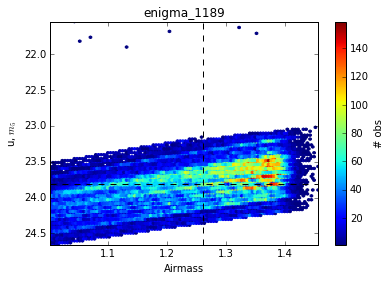

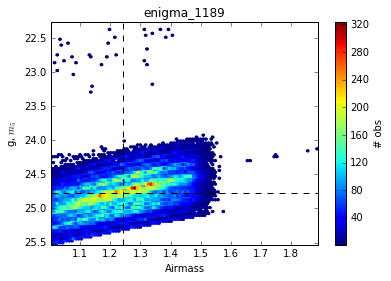

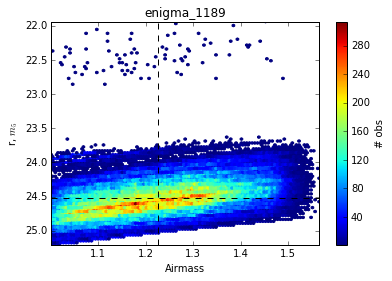

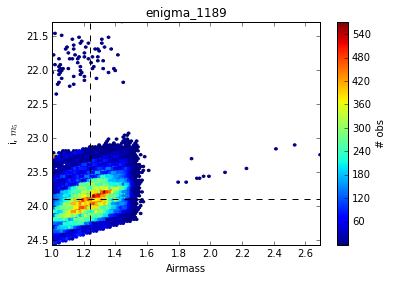

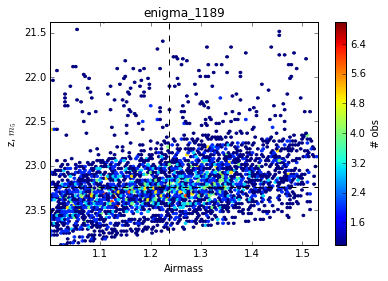

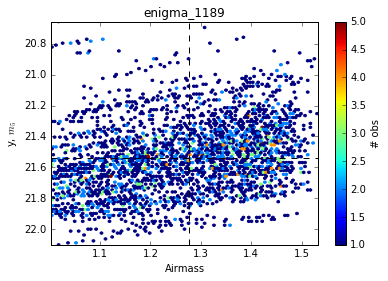

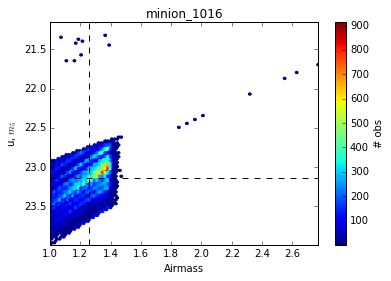

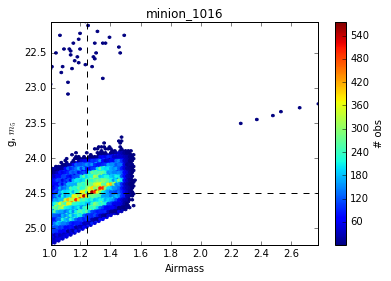

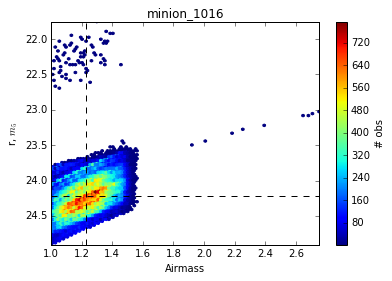

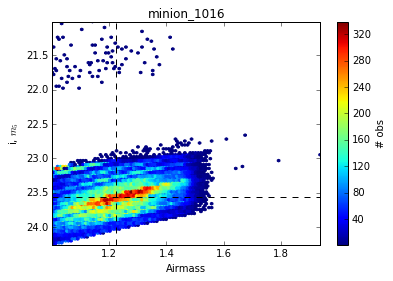

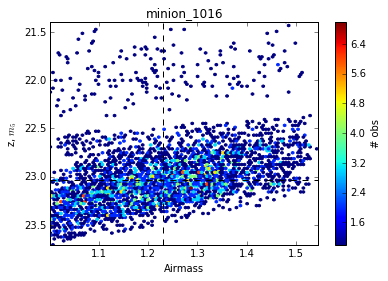

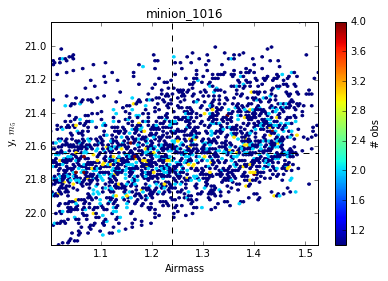

In [18]:
# Let's make a nice little contour plot
runNames = ['enigma_1189', 'minion_1016']
for runName in runNames:
    opsdb = db.OpsimDatabase(runName+'_sqlite.db')
    propids, propTags = opsdb.fetchPropInfo()
    WFDpropid = propTags['WFD'][0]
    for filterName in filters:
        sql = 'propID = %i and filter="%s" and moonAlt < %f and sunAlt < %f' % (WFDpropid, filterName, np.radians(-10.), np.radians(-18.))
        data = opsdb.fetchMetricData(['fiveSigmaDepth', 'airmass'], sql)
        plt.figure()
        plt.hexbin(data['airmass'], data['fiveSigmaDepth'], mincnt=1)
        plt.gca().invert_yaxis()
        plt.ylabel('%s, $m_5$' % filterName)
        plt.xlabel('Airmass')
        plt.title(runName)
        cb = plt.colorbar()
        cb.set_label('# obs')
        plt.axhline(np.median(data['fiveSigmaDepth']), color='k', linestyle='--')
        plt.axvline(np.median(data['airmass']), color='k', linestyle='--')